In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, VectorIndexer
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import chi2,SelectPercentile
from sklearn.neural_network import MLPRegressor
import seaborn as sns

In [20]:
data=pd.read_csv(r"C:\Users\AL-Renad\Documents\playing\mohammed\1 saving_dataset\Ames_Housing_Sales.csv")
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,SalePrice
0,856.0,854.0,0.0,None,3,1Fam,TA,No,706.0,0.0,...,0.0,Pave,8,856.0,AllPub,0.0,2003,2003,2008,208500.0
1,1262.0,0.0,0.0,None,3,1Fam,TA,Gd,978.0,0.0,...,0.0,Pave,6,1262.0,AllPub,298.0,1976,1976,2007,181500.0
2,920.0,866.0,0.0,None,3,1Fam,TA,Mn,486.0,0.0,...,0.0,Pave,6,920.0,AllPub,0.0,2001,2002,2008,223500.0
3,961.0,756.0,0.0,None,3,1Fam,Gd,No,216.0,0.0,...,0.0,Pave,7,756.0,AllPub,0.0,1915,1970,2006,140000.0
4,1145.0,1053.0,0.0,None,4,1Fam,TA,Av,655.0,0.0,...,0.0,Pave,9,1145.0,AllPub,192.0,2000,2000,2008,250000.0


In [21]:
data=data.drop(["Alley","BldgType","Utilities"],axis=1)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379 entries, 0 to 1378
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   1stFlrSF       1379 non-null   float64
 1   2ndFlrSF       1379 non-null   float64
 2   3SsnPorch      1379 non-null   float64
 3   BedroomAbvGr   1379 non-null   int64  
 4   BsmtCond       1379 non-null   object 
 5   BsmtExposure   1379 non-null   object 
 6   BsmtFinSF1     1379 non-null   float64
 7   BsmtFinSF2     1379 non-null   float64
 8   BsmtFinType1   1379 non-null   object 
 9   BsmtFinType2   1379 non-null   object 
 10  BsmtFullBath   1379 non-null   int64  
 11  BsmtHalfBath   1379 non-null   int64  
 12  BsmtQual       1379 non-null   object 
 13  BsmtUnfSF      1379 non-null   float64
 14  CentralAir     1379 non-null   object 
 15  Condition1     1379 non-null   object 
 16  Condition2     1379 non-null   object 
 17  Electrical     1379 non-null   object 
 18  Enclosed

In [6]:
data.describe()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,SalePrice
count,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,...,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.00000
mean,1177.129804,353.424946,3.609862,2.865120,455.578680,48.102248,0.430747,0.058738,570.765047,21.039159,...,6.187092,2.920957,15.945613,6.552574,1074.445975,97.456853,1972.958666,1985.435098,2007.812183,185479.51124
std,387.014961,439.553171,30.154682,0.783961,459.691379,164.324665,0.514052,0.238285,443.677845,60.535107,...,1.345780,41.335545,57.249593,1.589821,436.371874,126.699192,29.379883,20.444852,1.330221,79023.89060
min,438.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1880.000000,1950.000000,2006.000000,35311.00000
25%,894.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,228.000000,0.000000,...,5.000000,0.000000,0.000000,5.000000,810.000000,0.000000,1955.000000,1968.000000,2007.000000,134000.00000
50%,1098.000000,0.000000,0.000000,3.000000,400.000000,0.000000,0.000000,0.000000,476.000000,0.000000,...,6.000000,0.000000,0.000000,6.000000,1008.000000,0.000000,1976.000000,1994.000000,2008.000000,167500.00000
75%,1414.000000,738.500000,0.000000,3.000000,732.000000,0.000000,1.000000,0.000000,811.000000,0.000000,...,7.000000,0.000000,0.000000,7.000000,1314.000000,171.000000,2001.000000,2004.000000,2009.000000,217750.00000
max,4692.000000,2065.000000,508.000000,6.000000,5644.000000,1474.000000,2.000000,2.000000,2336.000000,552.000000,...,10.000000,738.000000,480.000000,12.000000,6110.000000,857.000000,2010.000000,2010.000000,2010.000000,755000.00000


In [8]:
data.shape

(1379, 77)

In [7]:
data.duplicated().sum()

0

In [9]:
data.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtCond',
       'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF',
       'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'EnclosedPorch',
       'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence',
       'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional',
       'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual',
       'GarageType', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Heating',
       'HeatingQC', 'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour',
       'LandSlope', 'LotArea', 'LotConfig', 'LotFrontage', 'LotShape',
       'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrArea', 'MasVnrType',
       'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood', 'OpenPorchSF',
       'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC',
       'RoofMatl', 'RoofSty

In [10]:
data.isnull().sum()

1stFlrSF        0
2ndFlrSF        0
3SsnPorch       0
BedroomAbvGr    0
BsmtCond        0
               ..
WoodDeckSF      0
YearBuilt       0
YearRemodAdd    0
YrSold          0
SalePrice       0
Length: 77, dtype: int64

In [11]:
data.isna().sum()

1stFlrSF        0
2ndFlrSF        0
3SsnPorch       0
BedroomAbvGr    0
BsmtCond        0
               ..
WoodDeckSF      0
YearBuilt       0
YearRemodAdd    0
YrSold          0
SalePrice       0
Length: 77, dtype: int64

In [22]:
# Perform one-hot encoding for all object-type columns
data_encoded = pd.get_dummies(data, columns=data.select_dtypes(include=['object']).columns, drop_first=True)
data_encoded.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleCondition_Partial,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Pave
0,856.0,854.0,0.0,3,706.0,0.0,1,0,150.0,0.0,...,0,0,0,0,0,0,0,0,1,1
1,1262.0,0.0,0.0,3,978.0,0.0,0,1,284.0,0.0,...,0,0,0,0,0,0,0,0,1,1
2,920.0,866.0,0.0,3,486.0,0.0,1,0,434.0,0.0,...,0,0,0,0,0,0,0,0,1,1
3,961.0,756.0,0.0,3,216.0,0.0,1,0,540.0,272.0,...,0,0,0,0,0,0,0,0,1,1
4,1145.0,1053.0,0.0,4,655.0,0.0,1,0,490.0,0.0,...,0,0,0,0,0,0,0,0,1,1


In [23]:
X=data_encoded.iloc[:,:-1]
print(X.shape)
y=data_encoded['SalePrice']
print(y.shape)

(1379, 244)
(1379,)


In [16]:
# from sklearn.preprocessing import StandardScaler
# std=StandardScaler()
# X=std.fit_transform(X,y)

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Ensure all values in X are non-negative
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

sel = SelectPercentile(chi2, percentile=20)
X_new = sel.fit(X, y)
X = X_new.transform(X)
X.shape

(1379, 49)

In [25]:
X_new.get_support()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False,  True,  True, False,  True,  True, False, False, False,
       False,  True, False, False,  True, False, False,  True, False,
        True, False, False, False,  True, False, False, False, False,
       False,  True, False,  True, False, False, False,  True, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False,

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtCond',
       'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF',
       'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'EnclosedPorch',
       'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence',
       'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional',
       'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual',
       'GarageType', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Heating',
       'HeatingQC', 'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour',
       'LandSlope', 'LotArea', 'LotConfig', 'LotFrontage', 'LotShape',
       'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrArea', 'MasVnrType',
       'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood', 'OpenPorchSF',
       'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC',
       'RoofMatl', 'RoofSty

In [26]:


plt.bar(X['TotRmsAbvGrd'],y)
plt.xlabel("TotRmsAbvGrd")
plt.ylabel('price')
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [28]:
plt.bar(X['YearBuilt'],y)
plt.xlabel('YearBuilt')
plt.ylabel('price')
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

(1379,)

In [13]:
from sklearn.feature_selection import SelectPercentile,chi2,SelectFromModel
from sklearn.linear_model import LinearRegression
lrg=LinearRegression()
X_new=SelectFromModel(estimator=lrg,max_features=None)
X=X_new.fit_transform(X,y)

X_new.get_support()

ValueError: could not convert string to float: 'None'

In [18]:
X.shape

(1379, 31)

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=40)

In [15]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ValueError: could not convert string to float: 'None'

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the model
rf = RandomForestRegressor(random_state=42)

# Define hyperparameters for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_scaled, y)

# Best model
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

In [ ]:
# Split the scaled data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=40)

# Train the best model
best_rf.fit(X_train, y_train)

# Evaluate the model
y_pred = best_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)

In [20]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso,SGDRegressor
linearrg=LinearRegression()
ridge=Ridge()
lasso=Lasso()
sdgr=SGDRegressor()



In [21]:
lasso.fit(X_train,y_train)
# print(linearrg.score(X_train,y_train))
# print(linearrg.score(X_test,y_test))
# print(linearrg.coef_)
# print(linearrg.intercept_)

c:\Users\AL-Renad\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.680e+09, tolerance: 6.709e+08
  model = cd_fast.enet_coordinate_descent(


Lasso()

In [22]:
y_pred=lasso.predict(X_test)
apserorr=mean_absolute_error(y_test,y_pred)
apserorr

54152.92565017173

In [23]:
from sklearn.metrics import mean_squared_error
squr=mean_squared_error(y_test,y_pred)
squr

6343525079.959187

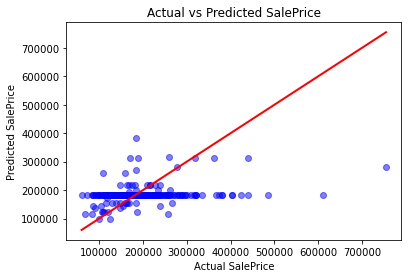

In [24]:
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)  # Line of perfect fit
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice")
plt.show()